<a href="https://colab.research.google.com/github/jovian-explorer/Short-Projects/blob/main/MCMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supernova MCMC and HMC exercise

## 1. Cosmology with Supernovae Ia

The aim of this exercise is to write an MCMC code to estimate cosmological parameters from supernova
Ia data. Supernova Ia are standard candles (or can be made so), so can be used to measure the contents
of the Universe.

In [ ]:
# importing libraries
import numpy as np
import math as m
import matplotlib.pyplot as plt
import pandas as pd
import random
import math as math

Link to my github: **https://github.com/jovian-explorer**

Used in this assignment for the purpose of importing the datasets for just a single time, rather than going through the whole process of uploading files, or mounting drive each time. 

##2. Theory and parameters

The flux from a supernova of flux $L$ is given by $$f = \frac{L}{4\pi D_L^2}$$ where $D_L$ is the $Luminosity$ $Distance$. In Big Bang cosmology, it is given by $$D_L = \frac{(1+z)c}{H_0 \sqrt{|1-\Omega|} S_k(r)}$$ where $$r(z) = \sqrt{|1-\Omega|} \int_0^z \frac{dz'}{\sqrt{\Omega_m(1+z')^3 + \Omega_v + (1-\Omega)(1+z')^2}}$$ and $S_k(r) = sin r, r, sinh$ $r$, depending on whether
 $\Omega \equiv \Omega_m + \Omega_v$ is $> 1$, $=1$, or $ < 1$ and $z$ is the observed redshift of the supernova. $\Omega_m, \Omega_v$ and $H_0$ are the density parameters (today) in matter, vacuum energy, and the Hubble constant. It is beyond the scope of these notes to derive this, but it is standard material for an undergraduate cosmology course.

For a flat universe ($\Omega = 1$), this simplifies to $$D_L(z) = 3000 h^{-1}(1+z) \int_0^z \frac{dz'}{\sqrt{\Omega_m(1+z')^3 + 1- \Omega_m}} Mpc, $$
where $H_0 = 100h$ km $s^{-1}$ $Mpc^{-1}$. To avoid evaluating integrals to calculate $D_L$, we can use an accurate fitting formula (valid for flat universes only), given by U.-L. Pen, ApJS, 120, 49 (1999):
$$D_L(z)=\frac{c}{H_0}(1+z) \left[\eta (1,\Omega_m) -\eta (\frac{1}{1+z},\Omega_m) \right]$$
where 
$$\eta(a,\Omega_m) = 2\sqrt{s^3 +1} \left[\frac{1}{a^4} - 0.1540 \frac{s}{a^3} + 0.4304\frac{s^2}{a^2} + 0.19097\frac{s^3}{a} + 0.066941 s^4 \right]^{-1/8}$$
and $s^3 \equiv (1-\Omega_m)/\Omega_m$. This is accurate to better than 0.4% for $0.2 \leq \Omega_m \leq 1$.

Fluxes are usually expressed in magnitudes, where $m = -2.5 log_{10} F +$ constant. The distance modulus is $\mu = m- M$ where $M$ is the absolute magnitude, which is the value of $m$ if the source is at a distance $10pc$. With $D_L$ in $Mpc^{1}$, this is $$\mu = 25 - 5 log_{10} h + 5 log_{10} (\frac{D_L^*}{Mpc}) $$
The Hubble constant has been factored out of $D_L: D_L^* \equiv D_L (h =1)$.

If we have measurements of $\mu$, then we can use Bayesian arguments to estimate the parameters $\Omega_m, \Omega_v,h.$ For anyone unfamiliar with cosmology, these numbers are somewhere between $0$ and $1$.

##3. Data

The data file (from the ‘JLA’ sample - see http://supernovae.in2p3.fr/sdss_snls_jla/ReadMe.html for more detail) consists of data from about $700$ supernovae, which are averaged together in $31$ narrow bins of redshift, to give a distance modulus μ for each bin.

The sample file jla_mub.txt contains $n = 31$ pairs of $(z,mu)$, corresponding to bins containing supernovae with $z < 1.3$. 

In [ ]:
# Data for 31 supernovae
url_1 = 'https://raw.githubusercontent.com/jovian-explorer/Short-Projects/main/astrostatistics/jla_mub_0.csv'     # link to the raw file for the dataset from my github
supernova = pd.read_csv(url_1,encoding='utf-8')

print(supernova.head()) #displaying the first 5 rows

       z         mu
0  0.010  32.953887
1  0.012  33.879003
2  0.014  33.842141
3  0.016  34.118567
4  0.019  34.593446


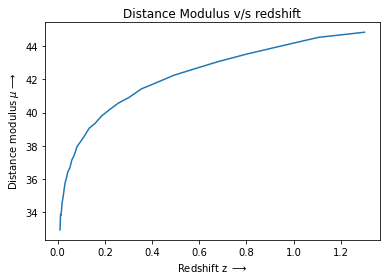

In [ ]:
supernova.columns = ["z","mu"]
z = np.array(supernova.z)                           #storing z values in array z
mu = np.array(supernova.mu)                         #storing mu values in array mu

plt.plot(z,mu)                                      #plot between z and mu
plt.xlabel('Redshift z $\longrightarrow$')          # x label
plt.ylabel('Distance modulus $\mu \longrightarrow$')#y label
plt.title('Distance Modulus v/s redshift')          # plot title
plt.show()

In [ ]:
# Data for the covmatrix of 31x31
url_2 = 'https://raw.githubusercontent.com/jovian-explorer/Short-Projects/main/astrostatistics/jla_mub_covmatrix.csv'      # link to the raw file for the dataset from my github
covmatrix = pd.read_csv(url_2,encoding='utf-8')

covmatrix.columns= ["C","-"]
arr = np.array(covmatrix.C)                   # storing the values into an array
C = np.reshape(arr, (31,31))                  # reshaping the array to 31x31
InvC=np.linalg.inv(C)                        # taking inverse

##4. Exercise

Write an MCMC code to estimate $h$ and $\Omega_m$ from the supernova dataset, assuming the Universe is flat and the errors are gaussian$^2$ , i.e. assume that the likelihood is

$$L \propto exp \left[ -\frac{1}{2} \sum_{i,j=1}^{n} [\mu_i - \mu_{th}(z_i)] C^{-1}_{ij}[\mu_j - \mu_{th}(z_j)] \right]$$

where $\mu_{th}$ is the theoretical value of the distance modulus, for which you will need to compute the integral for $D^*_L$ numerically, using the fitting formula (for a flat Universe). For clarity, we have not written the full dependence of $\mu_{th} ; $ we should write $\mu_{th} (z ; \Omega_m, h)$, and indeed it also depends on the (LCDM) model M.

$C$ is the $31$ × $31$ covariance matrix of the data, provided as a list of numbers in an obvious order, from the website, in the file jla_mub_covmatrix.txt.

*   h and $\Omega_m$ are positive, and have values of the rough order of unity.

*   Assume uniform priors on the parameters (so you estimate the likelihood).

*   You might like to start with a very simple ‘top-hat’ proposal distribution, where the new point is selected from a rectangular region centred on the old point. For this you will need a simple random number generator. Or use a gaussian for each parameter.

*   Explore visually the chain when you have (a) a very small proposal distribution, and (b) a very large proposal distribution, for a maximum of $1000$ trials. What do you conclude?

*   Show how the acceptance probability changes as you change the size of the proposal distribution from very small (say $0.001)$ to very large (say $100$).

*   Once you have settled on a ‘reasonable’ proposal distribution, compute the average value of the parameter estimates under the posterior distribution, and their variances and covariance.
*   Optionally, generalise to non-flat Universes and include $\Omega_v$ as an independent parameter.



###4.1. Tips  

If you are estimating $h$, $\Omega_m$ and $\Omega_v$, you can precalculate $D_L$ for $h = 1$ as a function of $\Omega_m$ and $\Omega_v$, and do a bilinear interpolation when you are running the chains (and divide by $h$). You only need to do this at the $31$ redshifts of the JLA sample. This will be much faster than computing $D_L$ every time you change parameters. This is not necessary if your parameters are $h$ and $\Omega_m$ only.

In [ ]:
#number of samples 
sample= 1000 #input('number of samples - ')
sampl = int(sample)
#number of parameters
par = 2

#assume the parameters having gaussian distribution
sig_om= 0.1
sig_h= 0.024
d_mu = np.empty(31)

In [ ]:
def eta( a, Omega_m ):
    s = (1/Omega_m -1.0)**(1/3)
    ETA = 2.0 * np.sqrt(np.power(s,3)+1.0) * np.power(np.power(a,-4)-0.1540*s*np.power(a,-3)+0.4304*np.power(s,2)*np.power(a,-2)+0.19097*np.power(s,3)/a+0.066941*np.power(s,4),-0.125)   
    return ETA

def D_L(z,Omega_m):
    DL = 3000.0*(1.0+z)*(eta(1.0,Omega_m)-eta(1.0/(1.0+z), Omega_m))
    return DL

def mu_modeled(z,Omega_m,h):
    mu_modeled = 25.0 - 5.0*math.log10(h) + 5.0*math.log10(D_L(z,Omega_m))
    return mu_modeled

def log_L(Omega_m, h):
    if(Omega_m<=0 or h<=0):
        log_L = -1.e100
    else:
        for j in range (31):
            d_mu[j] = mu[j]-mu_modeled(z[j],Omega_m,h)
        log_L = -0.5*np.dot(d_mu,np.dot(InvC,d_mu))
    return log_L

In [ ]:
mcmc= np.empty([sampl,par+1])
mcmc[0,0]= np.random.uniform()
mcmc[0,1]= 0.738

#Calculate an initial likelihood value in third coloumn
mcmc[0,2]=log_L(mcmc[0,0], mcmc[0,1])

##plt.figure()
for i in range(1,sampl):
    log_L_prv= mcmc[i-1,2]
    om_nxt= np.random.normal(mcmc[i-1,0],sig_om)
    h_nxt= np.random.normal(mcmc[i-1,1],sig_h)
    log_L_nxt= log_L(om_nxt,h_nxt)


    #Metropolis Hastings algorithm
   
    if(log_L_nxt>log_L_prv):
        mcmc[i,0]= om_nxt
        mcmc[i,1]= h_nxt
        mcmc[i,2]= log_L_nxt
        print("Accepted with high likelihood")
    else:
        x=np.random.uniform()
        if(log_L_nxt-log_L_prv>np.log(x)): 
            mcmc[i,0]= om_nxt
            mcmc[i,1]= h_nxt
            mcmc[i,2]= log_L_nxt
            print("Accepted with low likelihood")
        else:
            mcmc[i,0]= mcmc[i-1,0]
            mcmc[i,1]= mcmc[i-1,1]
            mcmc[i,2]= log_L_prv
            print("Rejected")
#For value calculation, we rejecting initial values and only selecting the values where the algorithm converges
#initial 5% of the values are rejected
reject= sampl//5

Rejected
Rejected
Accepted with high likelihood
Rejected
Rejected
Rejected
Rejected
Accepted with high likelihood
Rejected
Rejected
Rejected
Rejected
Rejected
Rejected
Accepted with low likelihood
Rejected
Rejected
Rejected
Rejected
Rejected
Accepted with high likelihood
Rejected
Rejected
Accepted with high likelihood
Rejected
Rejected
Rejected
Rejected
Rejected
Rejected
Accepted with high likelihood
Accepted with low likelihood
Rejected
Rejected
Rejected
Rejected
Rejected
Rejected
Rejected
Rejected
Accepted with low likelihood
Rejected
Accepted with high likelihood
Rejected
Accepted with high likelihood
Accepted with high likelihood
Rejected
Rejected
Rejected
Rejected
Rejected
Rejected
Rejected
Rejected
Rejected
Rejected
Rejected
Rejected
Rejected
Accepted with low likelihood
Rejected
Rejected
Rejected
Rejected
Accepted with low likelihood
Rejected
Rejected
Accepted with high likelihood
Rejected
Rejected
Accepted with high likelihood
Rejected
Rejected
Rejected
Rejected
Rejected
Reject

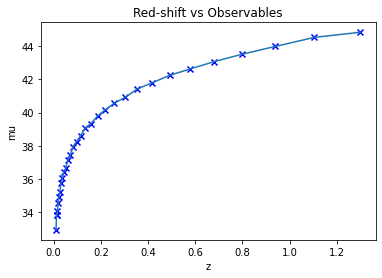

In [ ]:
#reading the Observable
plt.plot(z,mu)
plt.xlabel("z")
plt.ylabel('mu')
plt.scatter(z, mu, c='blue', marker='x')
plt.title('Red-shift vs Observables')
nam="Red-shift_vs_Observables_Plot_"+ str(sample)
plt.savefig(nam) 
plt.show()

In [ ]:

print('__________________________________________________________________________')
print('\n\n\nEstimated value of Omega_m = '+ str(np.mean(mcmc[reject:sampl,0])))
print('Estimated value of standard deviation of Omega_m = '+ str(np.std(mcmc[reject:sampl,0])))
print('--------------------------------------------------------------------------')
print('Estimated value of h = '+ str(np.mean(mcmc[reject:sampl,1])))
print('Estimated value of standard deviation of  h = '+ str(np.std(mcmc[reject:sampl,1])))
print('__________________________________________________________________________')

__________________________________________________________________________



Estimated value of Omega_m = 0.3014059805129807
Estimated value of standard deviation of Omega_m = 0.029026654003586526
--------------------------------------------------------------------------
Estimated value of h = 0.7015998625642738
Estimated value of standard deviation of  h = 0.007458095712914624
__________________________________________________________________________


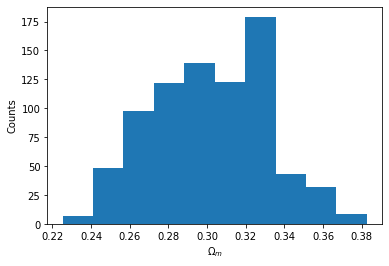

In [ ]:
#histogram showing values of Omega_m
plt.figure()
plt.hist(mcmc[reject:sampl,0])
plt.xlabel("$\Omega_m$")
plt.ylabel('Counts')
plt.show()

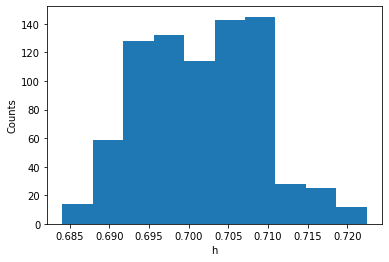

In [ ]:
#histogram showing values of h
plt.hist(mcmc[reject:sampl,1])
plt.xlabel("h")
plt.ylabel('Counts')
plt.show()

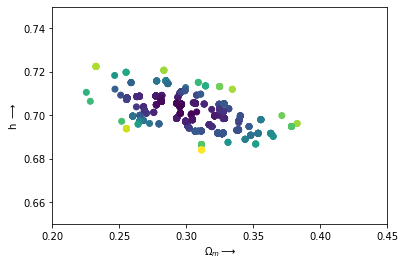

In [ ]:
# Scatter plot of samples
plt.scatter(mcmc[reject:,0], mcmc[reject:,1], c = -mcmc[reject:,par])
plt.xlim(0.20,0.45)
plt.ylim(0.65,0.75)
plt.xlabel('$\Omega_m \longrightarrow$')
plt.ylabel('h $\longrightarrow$')
plt.show() 

##5. Extensions 



*   Importance sampling. Consider a non-flat prior, so the target distribution is the posterior, not the likelihood. We can still sample from the likelihood (as you have been doing), and construct the posterior by weighting the points with the prior to get the target. This is an example of $importance$ $sampling$, where we sample from a different distribution from the one we eventually want. Apply a prior on the Hubble constant to your chain, assuming a gaussian prior with mean $0.738$ and standard deviation $0.024$. Now plotting all the points in the chain will give a graph which looks the same as your previous graphs, so what should you do? Compute the mean $h$, $\Omega_m$ with and without the prior.

*   Write and apply a Gelman-Rubin convergence test, and deduce roughly how long the chains should be for convergence.

*   Extend to perform Hamiltonian Monte Carlo. You might like to try to compare the performance of MCMC and HMC; you will need to decide what the right criterion is.

For HMC, the algorithm is (from Hajian 2006): 


```
1: initialize x(0)
2: for i = 1 to N_samples
3:       u ∼ N (0, 1) (Normal distribution)
4:       (x∗(0), u∗(0)) = (x(i−1), u)
5:       for j = 1 to N
6:             make a leapfrog move: (x∗(j−1), u∗(j−1)) → (x∗(j), u∗(j))
7:       end for
8:       (x∗, u∗) = (x(N), u(N))
9:       draw α ∼ Uniform(0,1)
10:      if α < min{1, e−(H(x∗,u∗)−H(x,u))}
11:           x(i) = x∗
12:      else
13:           x(i) = x(i−1)
14: end for
```

$H = − lnL + K$, where $K = u · u/2$. One approach is to approximate U by a bivariate gaussian with covariances estimated from the MCMC code (or you can try computing the derivative exactly):
$$U = \frac{1}{2} (\theta - \theta_0)_{\alpha} C^{-1}_{\alpha \beta}  (\theta - \theta_0)_{\beta}$$

You can evolve the system with a naive Euler method (not recommended in general for stability reasons), or use the leapfrog algorithm:

$$u_i \left( t+ \frac{\epsilon}{2} \right) = u_i(t) - \frac{\epsilon}{2} \left( \frac{\partial U}{\partial x_i} \right)_{x(t)} $$

$$x_i(t+ \epsilon) = x_i(t) + \epsilon u_i \left( t+\frac{\epsilon}{2}\right)$$

$$u_i(t + \epsilon)= u_i \left( t+\frac{\epsilon}{2} \right) - \frac{\epsilon}{2} \left( \frac{\partial U}{\partial x_i} \right)_{x(t+ \epsilon)}$$

Issues to consider are how many integration steps per point in the chain, and how big those steps are. For some discussion, see Hajian (2006), astroph/0608679.

In [ ]:
#Question part of next assignment submission so going to take full advantage of the submission deadline working on this